### *Chargement et Prétraitement de Données Textuelles à partir de Plusieurs Répertoires pour un Modèle NLP**  

on  parcourt plusieurs répertoires contenant des fichiers texte pour extraire leur contenu et les associe à des étiquettes basées sur les noms de répertoires.  

Les données collectées sont ensuite organisées dans un **DataFrame Pandas** avec deux colonnes :  
- **Content** : Le texte extrait de chaque fichier.  
- **Label** : Le nom du répertoire correspondant, utilisé comme étiquette.  



In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import os 

import pandas as pd

# Initialize the data dictionary to store the content and labels
data = {'Content': [], 'Label': []}

# List of directories to process
directories = [
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets//5_data',
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets/articles',
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets/bbc',
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets/articles_final_mediastack',
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets/articles_final_gnews',
    'C:/Users/rayan/Desktop/NLP_PROJECT/pretraiteme/datasets/articles_final_news'
]

# Process each directory
for directory in directories:
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            # Skip README.TXT file if present
            if filename == "README.TXT":
                continue
            
            # Read the content of the file
            file_path = os.path.join(dirname, filename)
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()

            # Use directory name as the label
            label = os.path.basename(dirname)

            # Append data to the dictionary
            data['Content'].append(content)
            data['Label'].append(label)

# Create a DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print(df.head())


                                             Content     Label
0  Lufthansa flies back to profit\n\nGerman airli...  business
1  Winn-Dixie files for bankruptcy\n\nUS supermar...  business
2  US economy still growing says Fed\n\nMost area...  business
3  Saab to build Cadillacs in Sweden\n\nGeneral M...  business
4  Bank voted 8-1 for no rate change\n\nThe decis...  business


### Unification des Étiquettes 



In [3]:
# Replace 'tech' with 'technologie' to unify labels
df['Label'] = df['Label'].replace('tech', 'technologie')
df['Label'] = df['Label'].replace('technologies', 'technology')
df = df[df['Label'] != 'technologie']

# Display unique labels
unique_labels = df['Label'].unique()
print("Unique Labels:")
print(unique_labels)


Unique Labels:
['business' 'entertainment' 'politics' 'sports' 'technology']


### Encodage Numérique des Étiquettes 
on transforme les étiquettes catégorielles textuelles en valeurs numériques et prépare les données pour un modèle de classification NLP.  

In [5]:
# Encode labels numerically
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

# Map numerical labels back to class names
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
print("Label Mapping:")
print(label_mapping)

# Separate features and labels
X = df['Content'].values
y = df['Label'].values


Label Mapping:
{0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sports', 4: 'technology'}


### Visualisation de la Distribution des Classes dans le Jeu de Données 


Label Counts:
3    1011
0    1010
2     917
1     886
4     500
Name: count, dtype: int64


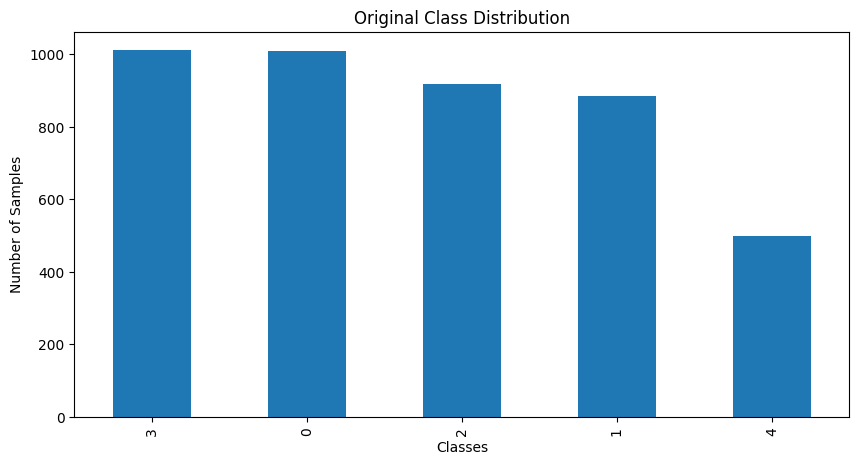

In [7]:
# Plot class distribution
label_counts = pd.Series(y).value_counts()
print("Label Counts:")
print(label_counts)

label_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Original Class Distribution')
plt.show()


### Nettoyage et Prétraitement de Texte 


1. On supprime les éléments indésirables tels que les balises HTML, la ponctuation, les chiffres et les espaces supplémentaires, tout en normalisant le texte en minuscules.  


In [9]:

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Text Cleaning Function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


2. Nettoyage du texte - Suppression des caractères spéciaux, des ponctuations, et mise en forme cohérente (fonction clean_text).
3. Traitement linguistique - Tokenisation des mots, suppression des mots vides (stopwords), et lemmatisation pour réduire les mots à leur forme de base (fonction preprocess_text).

In [11]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer

# Télécharger les stopwords et modèles nécessaires
nltk.download('stopwords')
spacy.cli.download('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')

# Récupérer les stopwords de chaque méthode
nltk_stop_words = set(stopwords.words('english'))
sklearn_stop_words = ENGLISH_STOP_WORDS
spacy_stop_words = nlp.Defaults.stop_words
gensim_stop_words = STOPWORDS

# Combiner toutes les listes de stopwords en un seul ensemble
all_stop_words = nltk_stop_words.union(sklearn_stop_words).union(spacy_stop_words).union(gensim_stop_words)

# Fonction de prétraitement mise à jour
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    words = [word for word in words if word.lower() not in all_stop_words]  # Filtrer les stopwords combinés
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply text cleaning and preprocessing
df['Content'] = df['Content'].apply(clean_text)
df['Content'] = df['Content'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



4. 
   - Supprime les lignes vides dans la colonne 'Content'.  
   - Élimine les doublons pour éviter les biais dans l’entraînement du modèle.  

5. **Visualisation de la distribution des classes**  
   - Compte le nombre d’échantillons pour chaque classe dans la colonne 'Label'.  
   - Affiche ces informations sous forme de graphique en barres pour faciliter l’analyse de l’équilibre des classes.  


Label Counts:
Label
0    711
3    683
2    618
1    561
4    283
Name: count, dtype: int64


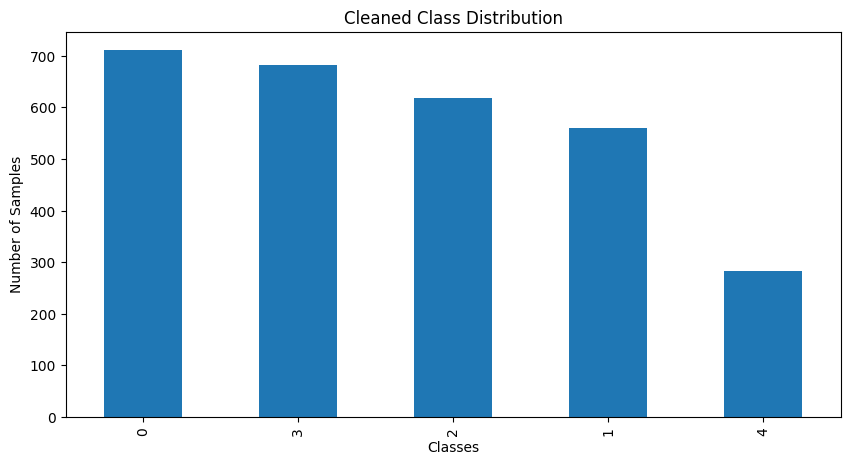

In [16]:
# Remove empty rows and duplicates
df = df[df['Content'].str.strip() != '']
df.drop_duplicates(subset=['Content'], inplace=True)

# Plot class distribution
label_counts = df['Label'].value_counts()
print("Label Counts:")
print(label_counts)

label_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Cleaned Class Distribution')
plt.show()

### Préparation pour l'Augmentation des Données Textuelles avec WordNet

Explication :
on importe et configure les bibliothèques nécessaires pour effectuer l’augmentation des données textuelles en utilisant WordNet. Voici ce qu’il fait :

Téléchargement des Ressources NLP :

1. WordNet : Base de données lexicale en anglais pour trouver des synonymes et des relations sémantiques.
2. omw-1.4 : Ressources supplémentaires pour WordNet.
3. POS Tagger (Part-of-Speech Tagging) : Permet d’étiqueter les mots selon leur type grammatical (nom, verbe, adjectif, etc.).


In [19]:
import random
from nltk.corpus import wordnet
from nltk import pos_tag
import nltk
# Téléchargement des ressources nécessaires
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rayan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### "Augmentation des Données Textuelles par Remplacement Synonymique"**

on  effectue une **augmentation des données textuelles** en remplaçant aléatoirement certains mots par leurs synonymes, basés sur **WordNet**. Cela aide à diversifier les données d’entraînement pour améliorer la robustesse des modèles de classification.  

---

### **Détails des Fonctions :**  

1. **`get_synonym(word)`**  
   - Recherche les synonymes d’un mot en utilisant **WordNet**.  
   - Retourne un mot aléatoire parmi les synonymes disponibles, en évitant les doublons ou le mot d’origine.  
   - Si aucun synonyme n’est trouvé, retourne le mot original.  

2. **`synonym_replacement(sentence, n=1)`**  
   - Tokenise la phrase en mots individuels.  
   - Effectue un **tagging grammatical (POS)** pour identifier les noms (NN), verbes (VB) et adjectifs (JJ), qui sont les plus pertinents pour un remplacement sémantique.  
   - Remplace jusqu’à **n mots** sélectionnés aléatoirement parmi les mots éligibles par des synonymes.  
   - Génère une phrase augmentée en conservant le contexte grammatical.  



### **Applications :**  
1. **Équilibrer des classes déséquilibrées** en ajoutant de nouvelles variantes textuelles.  
2. **Réduire l'overfitting** en diversifiant les exemples d’entraînement.  
3. **Améliorer la robustesse** des modèles face à des synonymes et reformulations.  

---



In [22]:
def get_synonym(word):
    synonyms = wordnet.synsets(word)
    if synonyms:
        synonym_list = set([lemma.name() for syn in synonyms for lemma in syn.lemmas()])
        if word in synonym_list:
            synonym_list.remove(word)
        if synonym_list:
            return random.choice(list(synonym_list))
    return word

def synonym_replacement(sentence, percent=90):
    words = nltk.word_tokenize(sentence)
    words_pos = nltk.pos_tag(words)
    
    eligible_words = [word for word, pos in words_pos if pos.startswith('NN') or pos.startswith('VB') or pos.startswith('JJ')]
    num_to_replace = max(1, int(len(eligible_words) * percent / 100))
    
    words_to_replace = random.sample(eligible_words, num_to_replace)
    
    new_sentence = []
    for word in words:
        if word in words_to_replace:
            new_sentence.append(get_synonym(word))
        else:
            new_sentence.append(word)
    
    return ' '.join(new_sentence)

# Exemple d'utilisation
sentence = "The quick brown fox jumps over the lazy dog."
percent_to_replace = 90  # Changez cette valeur selon votre besoin
new_sentence = synonym_replacement(sentence, percent=percent_to_replace)
print("Original sentence:", sentence)
print("Augmented sentence:", new_sentence)


Original sentence: The quick brown fox jumps over the lazy dog.
Augmented sentence: The promptly brown fuddle leap_out over the otiose wiener .


1. **Identification du Label Majoritaire :**  
   - Calcule la taille de la classe majoritaire (le nombre d’échantillons dans la classe la plus représentée).  

2. **Création de Données Augmentées :**  
   - Pour chaque classe minoritaire, calcule combien d’exemples supplémentaires sont nécessaires pour atteindre le nombre d’échantillons de la classe majoritaire.  
   - Génère ces exemples en appliquant la fonction **`synonym_replacement`** sur des textes sélectionnés aléatoirement.  
   - Remplace jusqu’à **5 mots** dans chaque texte par des synonymes pour en créer une version légèrement modifiée tout en conservant le sens général.  

3. **Fusion des Données :**  
   - Combine les exemples augmentés avec le dataset original.  
   - Met à jour la répartition des classes pour assurer l’équilibre.  

4. **Validation :**  
   - Affiche la nouvelle distribution des labels pour vérifier l’équilibre des classes après augmentation.  


In [24]:
# Obtenir le label majoritaire pour comparaison
majority_label_count = df['Label'].value_counts().max()

# Appliquer la data augmentation aux classes minoritaires
augmented_data = {'Content': [], 'Label': []}

for label in df['Label'].unique():
    subset = df[df['Label'] == label]
    current_count = len(subset)
    
    if current_count < majority_label_count:
        needed_samples = majority_label_count - current_count
        for i in range(needed_samples):
            # Choisir un exemple aléatoire
            original_text = subset.sample(1)['Content'].values[0]
            augmented_text = synonym_replacement(original_text, percent=90)  # Remplacer 90%
            augmented_data['Content'].append(augmented_text)
            augmented_data['Label'].append(label)

# Convertir les exemples augmentés en DataFrame
augmented_df = pd.DataFrame(augmented_data)

# Ajouter les données augmentées au DataFrame original
df = pd.concat([df, augmented_df], ignore_index=True)

# Afficher la répartition des labels après augmentation
print(df['Label'].value_counts())


Label
0    711
1    711
2    711
3    711
4    711
Name: count, dtype: int64


### Visualisation de la Répartition des Classes Après Augmentation des Données



Label Counts After Augmentation:
Label
0    711
1    711
2    711
3    711
4    711
Name: count, dtype: int64


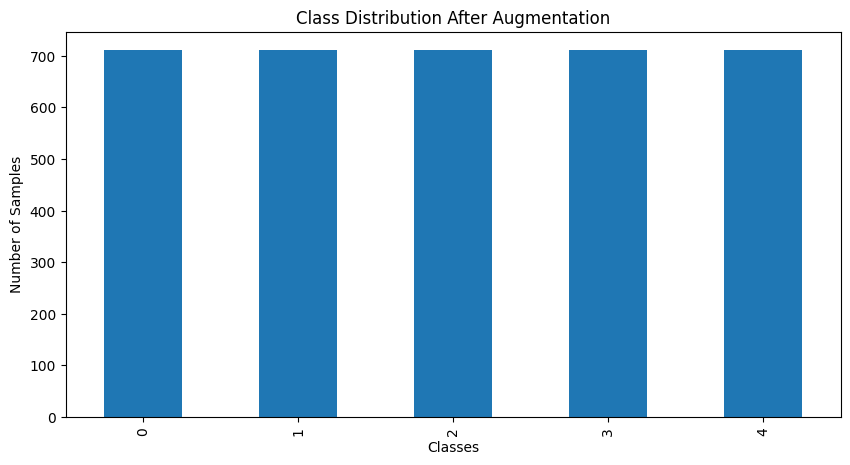

In [26]:
# Plot class distribution
label_counts = df['Label'].value_counts()
print("Label Counts After Augmentation:")
print(label_counts)

label_counts.plot(kind='bar', figsize=(10,5))
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Augmentation')
plt.show()

### Sauvegarde des Données Prétraitées et Équilibrées

In [107]:
# Save processed data
df.to_csv('data1.csv', index=False, columns=['Content', 'Label'])
print('Data saved to data1.csv')

Data saved to data1.csv


### Visualisation des Mots Fréquents par Classe avec des Nuages de Mots
On génère des nuages de mots (Word Clouds) pour chaque classe dans le jeu de données, afin d’identifier visuellement les termes les plus fréquents associés à chaque catégorie.

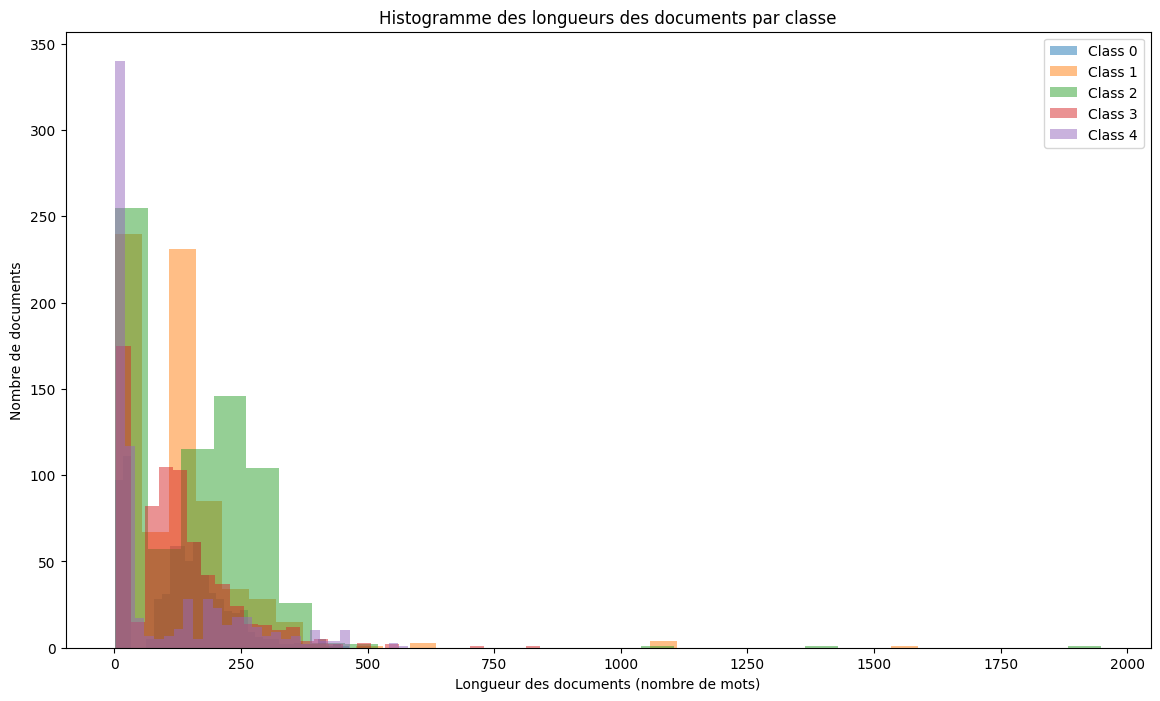

In [34]:
# Calculate document length (in number of words) for each document


df['Document Length'] = df['Content'].apply(lambda x: len(x.split()))

# Tracer l'histogramme des longueurs des documents pour chaque classe
plt.figure(figsize=(14, 8))
for label in df['Label'].unique():  # Remplacer 'Domain_Label' par 'Label'
    subset = df[df['Label'] == label]  # Remplacer 'Domain_Label' par 'Label'
    plt.hist(subset['Document Length'], bins=30, alpha=0.5, label=f'Class {label}')

plt.title('Histogramme des longueurs des documents par classe')
plt.xlabel('Longueur des documents (nombre de mots)')
plt.ylabel('Nombre de documents')
plt.legend()
plt.show()



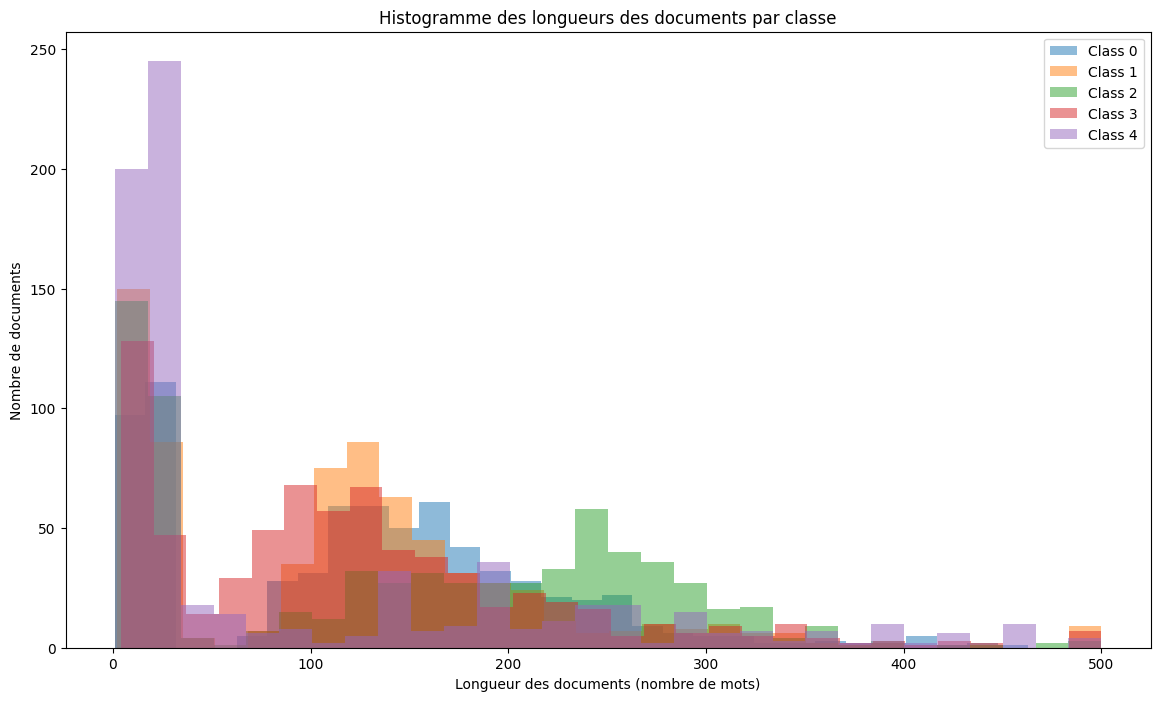

In [36]:
# Calculer la longueur des documents en nombre de mots
df['Document Length'] = df['Content'].apply(lambda x: len(x.split()))

# Limiter les documents à 500 mots maximum
df['Content'] = df['Content'].apply(lambda x: ' '.join(x.split()[:500]))  # Tronquer à 500 mots
df['Document Length'] = df['Content'].apply(lambda x: len(x.split()))  # Recalculer la longueur du document après tronquage

# Tracer l'histogramme des longueurs des documents pour chaque classe
plt.figure(figsize=(14, 8))
for label in df['Label'].unique():  # Remplacer 'Label' par la colonne de votre étiquette de classe
    subset = df[df['Label'] == label]  # Filtrer par classe
    plt.hist(subset['Document Length'], bins=30, alpha=0.5, label=f'Class {label}')

plt.title('Histogramme des longueurs des documents par classe')
plt.xlabel('Longueur des documents (nombre de mots)')
plt.ylabel('Nombre de documents')
plt.legend()
plt.show()


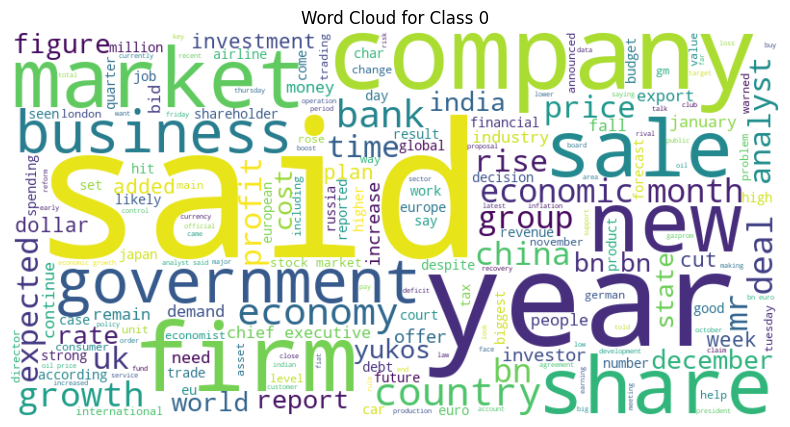

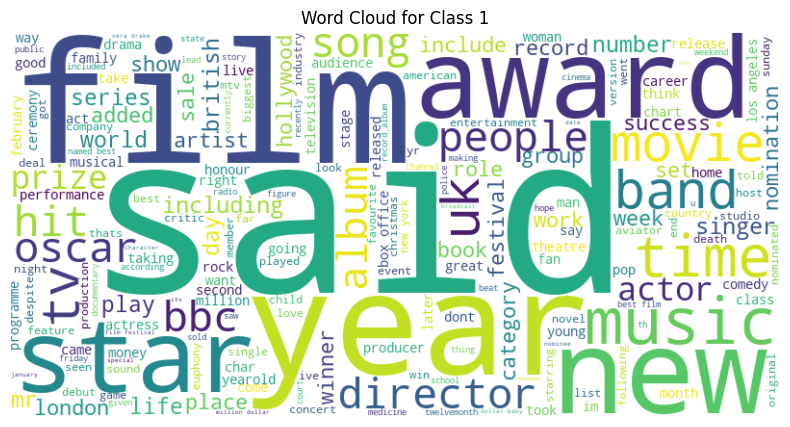

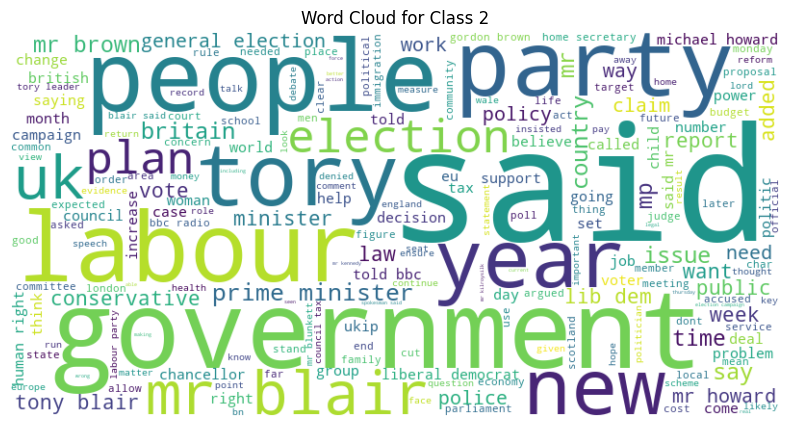

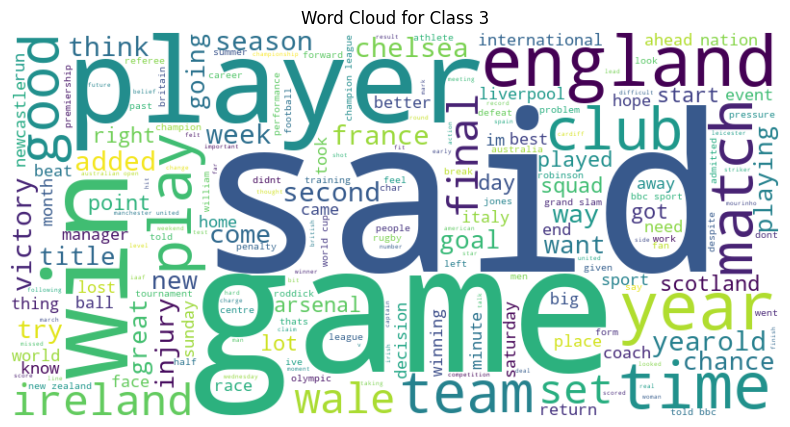

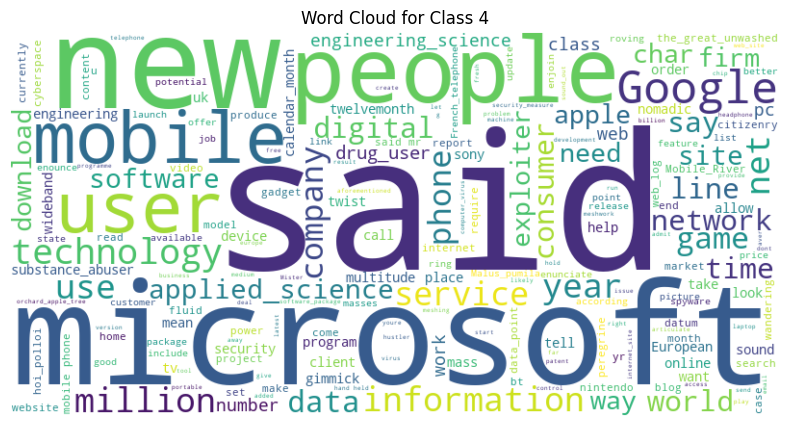

In [38]:
from wordcloud import WordCloud  # Import manquant ajouté


# Create word clouds for each class
for label in df['Label'].unique():
    text = ' '.join(df[df['Label'] == label]['Content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Class {label}')
    plt.show()


### Création d'une Liste Personnalisée de Stopwords pour Améliorer la Classification des Textes

Lors de l'etape passe , il a été observé que les **mots les plus fréquents** ne contribuent **pas efficacement à l'identification des classes**. Ces mots, souvent génériques, apparaissent dans plusieurs catégories et n'apportent aucune information discriminante pour la classification.

---

### **Décision Justificative :**  
Pour résoudre ce problème, une **liste personnalisée de stopwords** a été créée afin de :  
1. **Réduire le bruit** dans les données textuelles.  
2. **Améliorer la qualité des caractéristiques** utilisées par les modèles de machine learning.  
3. **Optimiser la performance de classification** en éliminant les mots non pertinents.  

---

### **Méthodologie Adoptée :**  
1. **Analyse TF-IDF :**  
   - Identification des mots apparaissant fréquemment dans le corpus.  
   - Calcul de la fréquence documentaire (présence dans au moins **5 % des documents**).  

2. **Fusion avec une Liste Personnalisée :**  
   - Ajout de pronoms et mots courants comme **'you', 'they', 'their'**.  
   - Suppression des mots détectés comme **très fréquents et non discriminants**.  

3. **Enregistrement dans un Fichier :**  
   - Création d'un fichier **`mots_communs_stopwords.txt`** pour conserver ces stopwords personnalisés.  
   - Réutilisable pour d’autres projets ou analyses.  

---



In [39]:

from sklearn.feature_extraction.text import TfidfVectorizer

# Liste de stopwords personnalisés
stopwords_personnalises = [
    'i', 'you', 'your', 'yours', 'he', 'she', 'it', 'we', 'they', 'them', 'their', 
    'ours', 'ourselves', 'him', 'hers', 'herself', 'himself', 'themselves', 'yourselves'
]

# Initialiser le vectoriseur TF-IDF avec les stopwords personnalisés
vectorizer = TfidfVectorizer(stop_words='english',  # Stopwords intégrés en anglais
                             token_pattern=r'\b[a-zA-Z]{2,}\b',  # Mots avec 2 lettres ou plus
                             lowercase=True)

# Calculer la matrice TF-IDF
tfidf_matrix = vectorizer.fit_transform(df['Content'])
terms = vectorizer.get_feature_names_out()

# Calculer la fréquence des mots dans les documents
word_counts = np.sum(tfidf_matrix.toarray() > 0, axis=0)

# Calculer la proportion des documents contenant chaque mot
doc_freq = word_counts / len(df)

# Sélectionner les mots apparaissant dans plus de () % des documents
mots_communs = [terms[i] for i in range(len(terms)) if doc_freq[i] > 0.05]

# Ajouter les mots communs détectés aux stopwords personnalisés
stopwords_finales = set(stopwords_personnalises + mots_communs)

# Enregistrer la liste finale des stopwords dans un fichier texte
with open('mots_communs_stopwords.txt', 'w') as f:
    for mot in stopwords_finales:
        f.write(f"{mot}\n")

# Afficher la liste des stopwords
print("Stopwords personnalisés et communs :", stopwords_finales)


Stopwords personnalisés et communs : {'right', 'britain', 'performance', 'year', 'seen', 'held', 'point', 'tory', 'john', 'later', 'increase', 'rise', 'recent', 'important', 'left', 'earlier', 'bn', 'likely', 'called', 'yearold', 'know', 'good', 'took', 'end', 'believe', 'big', 'world', 'their', 'said', 'order', 'way', 'industry', 'themselves', 'business', 'million', 'company', 'economy', 'got', 'he', 'going', 'sunday', 'thought', 'family', 'law', 'looking', 'cut', 'high', 'london', 'plan', 'i', 'you', 'saying', 'given', 'lot', 'film', 'play', 'issue', 'demand', 'europe', 'time', 'record', 'figure', 'strong', 'return', 'need', 'analyst', 'chance', 'tv', 'think', 'im', 'taking', 'january', 'added', 'bbc', 'him', 'open', 'better', 'monday', 'state', 'party', 'past', 'making', 'december', 'executive', 'lost', 'despite', 'future', 'little', 'continue', 'minister', 'biggest', 'place', 'action', 'win', 'yours', 'market', 'played', 'thursday', 'england', 'ahead', 'campaign', 'month', 'deal', 

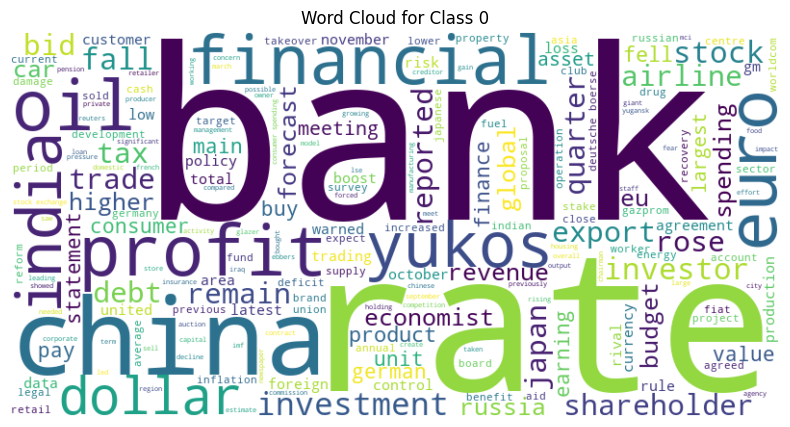

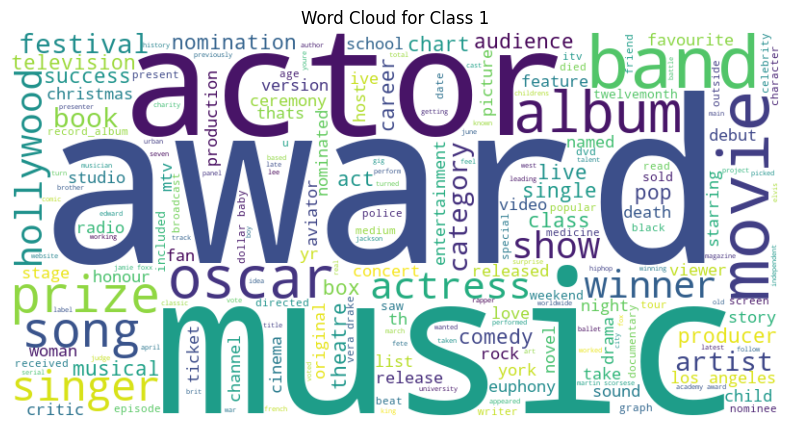

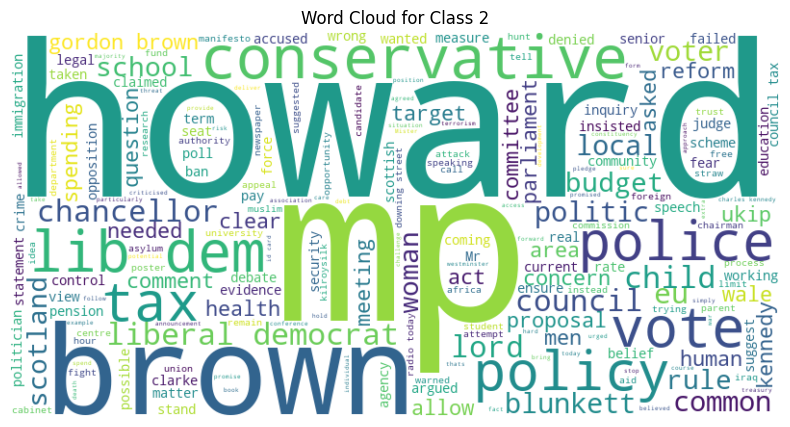

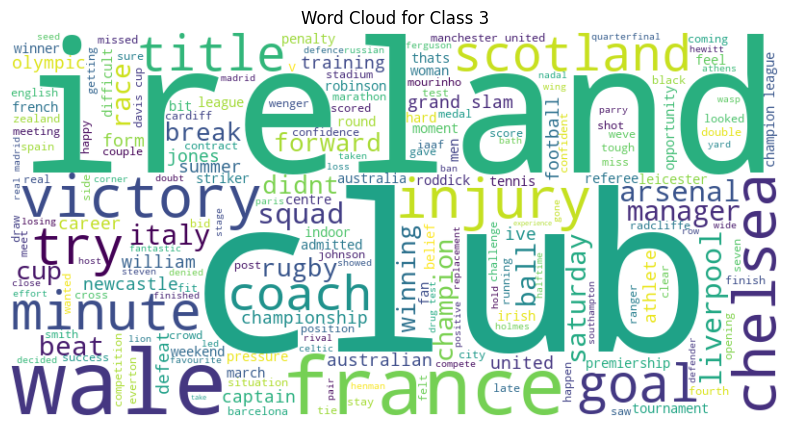

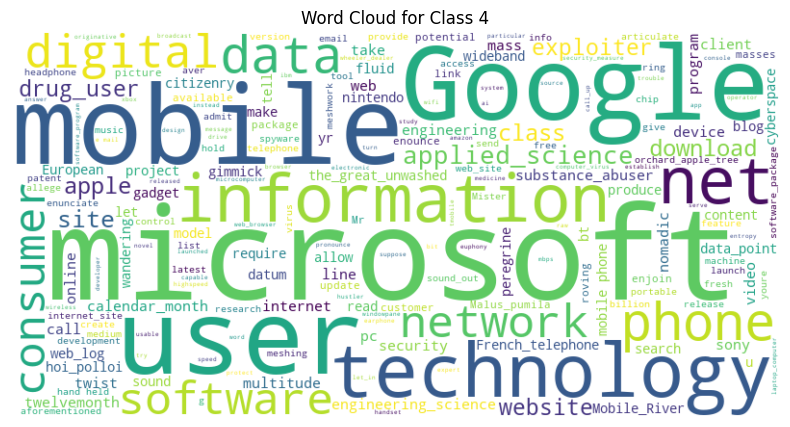

In [42]:
# Suppression des stopwords final dans les contenus
df['Content'] = df['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_finales]))

# Création des nuages de mots pour chaque classe
for label in df['Label'].unique():
    text = ' '.join(df[df['Label'] == label]['Content'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Class {label}')
    plt.show()

In [43]:
# Sauvegarder le dataset après nettoyage et analyse
df.to_csv('dataset_final.csv', index=False)
print("Le dataset nettoyé a été sauvegardé sous 'dataset_final.csv'")


Le dataset nettoyé a été sauvegardé sous 'cleaned_dataset.csv'


### Analyse des Termes Significatifs avec TF-IDF pour Chaque Classe


On utilise le **TF-IDF Vectorizer** pour extraire et analyser les termes les plus significatifs pour chaque classe dans un jeu de données textuel, en filtrant les mots fréquents et inutiles, tels que les **stopwords**. Le but est de mettre en évidence les termes qui sont les plus discriminants pour chaque classe en fonction de leur **TF-IDF moyen**.  


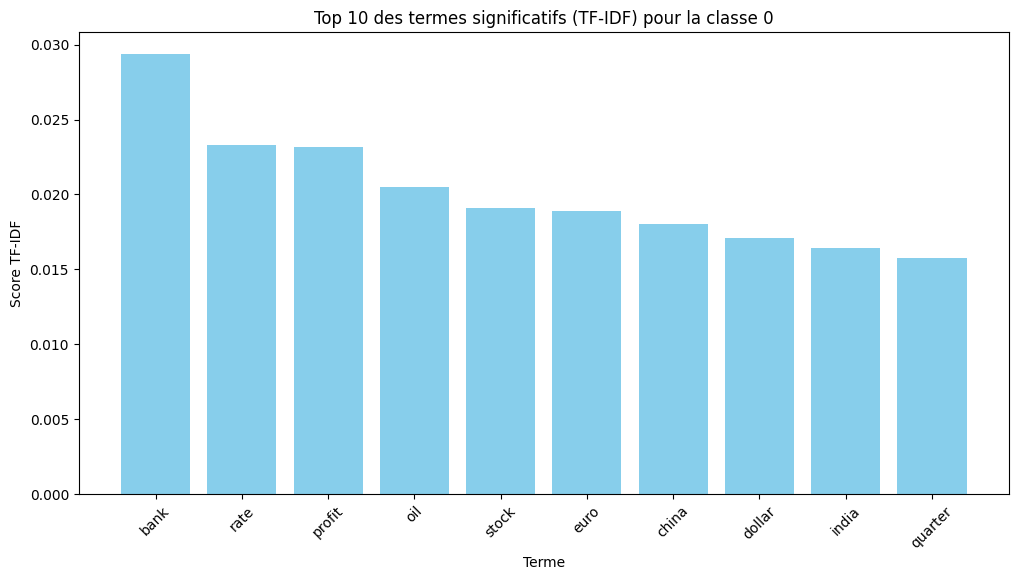

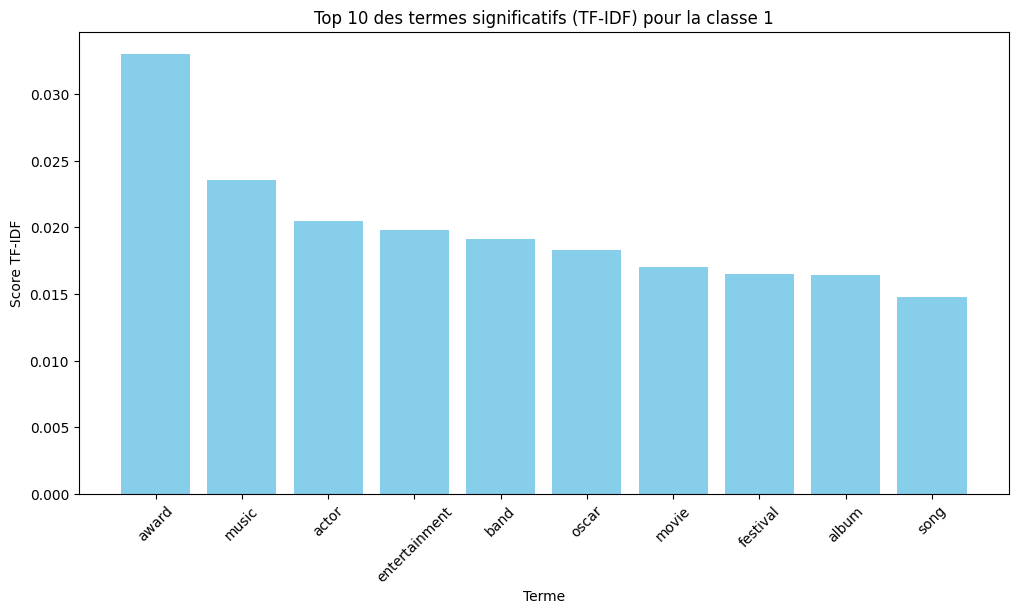

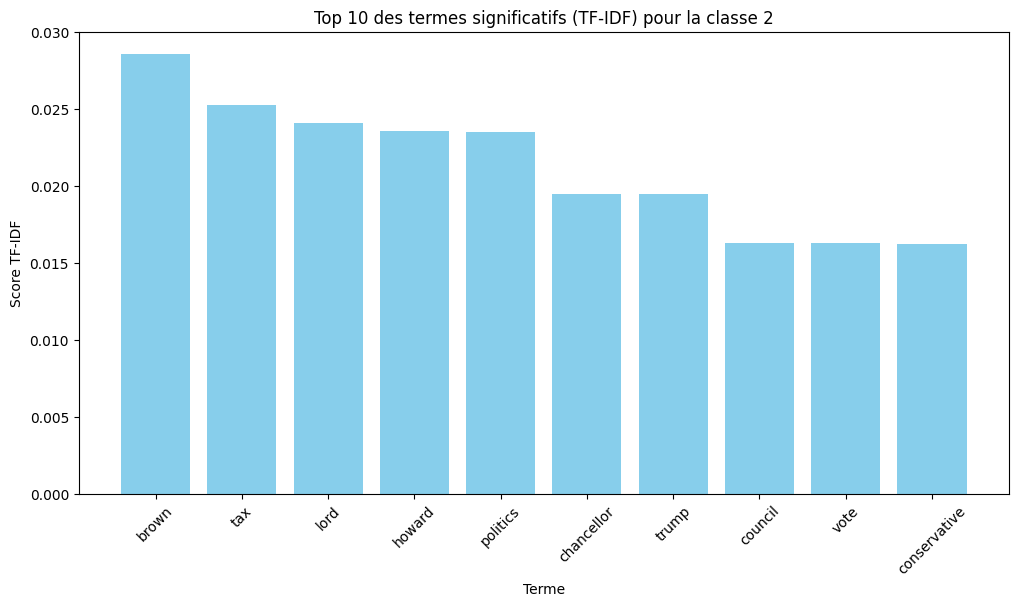

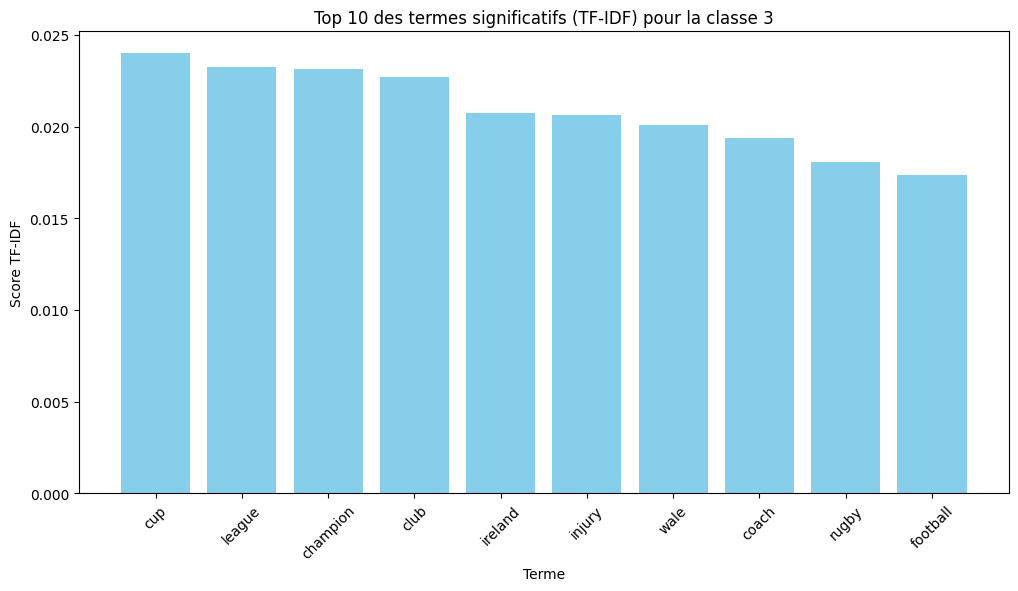

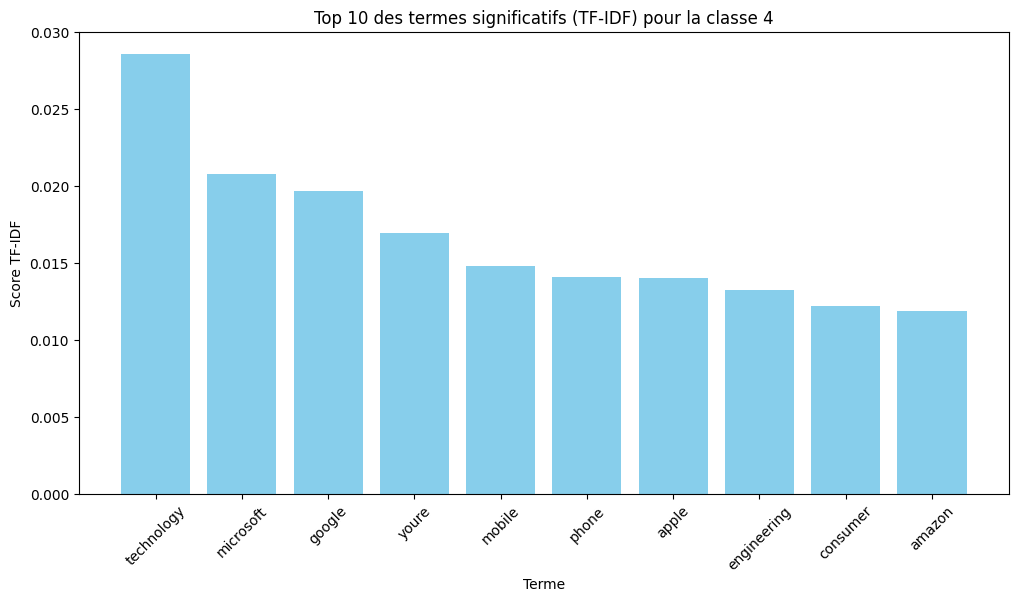

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
# TF-IDF Vectorizer avec filtres
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, 
                             min_df=2, max_df=0.8, 
                             token_pattern=r'\b[a-zA-Z]{3,}\b',  # Mot avec au moins 3 lettres
                             lowercase=True)

# Analyse des termes spécifiques pour chaque classe
for label in df['Label'].unique():
    # Filtrer les textes par classe
    texts = df[df['Label'] == label]['Content'].astype(str)
    
    # Calculer la matrice TF-IDF
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Extraire les scores TF-IDF moyens pour chaque terme
    tfidf_scores = tfidf_matrix.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    
    # Créer un DataFrame pour stocker les termes et leurs scores TF-IDF
    tfidf_df = pd.DataFrame({'Term': terms, 'Score': tfidf_scores})
    
    # Supprimer les mots personnalisés inutiles
    tfidf_df = tfidf_df[~tfidf_df['Term'].isin(stopwords_finales)]
    
    # Trier par score décroissant et sélectionner les 10 termes les plus significatifs
    tfidf_df = tfidf_df.sort_values(by='Score', ascending=False).head(10)
    
    # Visualiser les scores TF-IDF
    plt.figure(figsize=(12, 6))
    plt.bar(tfidf_df['Term'], tfidf_df['Score'], color='skyblue')
    plt.title(f"Top 10 des termes significatifs (TF-IDF) pour la classe {label}")
    plt.xlabel("Terme")
    plt.ylabel("Score TF-IDF")
    plt.xticks(rotation=45)
    plt.show()
